# Agent-based Network Model
Buyannemekh Munkhbat

Agent based model

In [10]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from ipywidgets import interact
import matplotlib.pyplot as plt
import networkx as nx
import collections
import warnings
warnings.filterwarnings('ignore')

## Infection state class that keeps track of infected persons

In [11]:
import random
import numpy as np


class InfectionState:
    def __init__(self, number_of_people, number_of_initial_infected, abnm:bool):
        self.number_of_people = number_of_people
        self.number_of_initial_infected = number_of_initial_infected
        self.abnm = abnm
        self.old_infected = set()
        self.newly_infected = set()
        self.discovered = set()
        self.initally_infected = set()
        self.num_discovered = 0
        self.color_map = ["green"] * self.number_of_people
        self.add_initial_infected_people()

    def add_initial_infected_people(self):
        # This is when pa_comm
        infected_indexes = random.sample(range(0, self.number_of_people),
                                            int(self.number_of_initial_infected))
        self.newly_infected = set(infected_indexes)
        self.initally_infected = set(infected_indexes)

    def get_old_infected(self):
        return self.old_infected

    def get_num_infected(self):
        return len(self.old_infected)

    def get_newly_infected(self):
        return self.newly_infected

    def get_num_discovered(self):
        return len(self.discovered)

    def get_discovered(self):
        return self.discovered

    def make_discovered(self, index_of_person: int):
        self.discovered.add(index_of_person)

    def set_num_discovered(self, num_discovered: int):
        self.num_discovered = num_discovered

    def make_infected(self, index_of_person: int):
        self.newly_infected.add(index_of_person)
        if index_of_person not in self.discovered:
            self.make_discovered(index_of_person=index_of_person)

    def is_old_infected(self, index_of_person: int):
        return index_of_person in self.old_infected

    def is_infected(self, index_of_person: int):
        return (index_of_person in self.newly_infected) or (index_of_person in self.old_infected)

    def close_newly_infected(self):
        self.old_infected.update(self.newly_infected)
        self.newly_infected = set()

## Infection progressor class that determines next infected persons

In [12]:
from networkx.classes.graph import Graph
class InfectionProgressor:

    def __init__(self, beta: float, graph: Graph , infection_state: InfectionState):
        self.beta = beta
        self.graph = graph
        self.infection_state = infection_state
        self.transmitted_edges = []

    def progress_all(self):
        for node in self.infection_state.get_old_infected():
            for nbr in self.graph.neighbors(node):
                transmitted_edge = self.progress(nbr)
                if transmitted_edge:
                    self.transmitted_edges.append(transmitted_edge)
        return self.transmitted_edges

    def progress(self, node):
        all_infected_contacts = set()

        if self.infection_state.is_infected(node):
            return None

        for nbr in self.graph[node]:
            if self.infection_state.is_old_infected(nbr):
                all_infected_contacts.add(nbr)

        total_infected_contacts = len(all_infected_contacts)

        if total_infected_contacts > 0:
            probability_to_infect = self.get_probability_to_infect(total_infected_contacts)

            if random.random() < probability_to_infect:
                self.infection_state.make_infected(node)
                transmitted_node = random.choice(tuple(all_infected_contacts))
                transmitted_edge = (transmitted_node, node)
                return transmitted_edge
            else:
                return None
        else:
            return None

    def get_probability_to_infect(self, total_infected_contacts):
        return 1-(1-self.beta)**total_infected_contacts

## Get degree distribution of the network and plot 

In [13]:
def get_degree_distribution(G):
    degree_dict = G.degree()
    degree_sequence = sorted([d for n, d in degree_dict], reverse=False)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    return deg, cnt

def plot_degree_distribution(deg, cnt):
    plt.figure()
    plt.plot(deg, cnt)
    plt.title("Degree distribution of the graph")

## Existing random graph generators

In [14]:
# wrap a few graph generation functions so they have the same signature
def powerlaw_cluster(n, m, k, p):
    return nx.powerlaw_cluster_graph(n, m, p)

def erdos_renyi(n, m, k, p):
    return nx.erdos_renyi_graph(n, p)

def newman_watts_strogatz(n, m, k, p):
    return nx.newman_watts_strogatz_graph(n, k, p)

def plot_random_graph(n, m, k, p, generator):
    g = generator(n, m, k, p)
    nx.draw(g)
    plt.show()   
    deg, cnt = get_degree_distribution(g)
    plot_degree_distribution(deg, cnt)

## The main ABNM class that initializes and runs the simulation

In [15]:
class ABNMExperiment:
    def __init__(self, model, num_nodes, num_edges, p,
                 number_of_initial_infected,
                 population_p,
                 beta,
                 verbose,
                 plot):
        # Model and initial settings
        self.model = model
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.p = p
        self.number_of_initial_infected = number_of_initial_infected

        # Infection properties
        self.population_p = population_p
        self.beta = beta
        self.infection_state = InfectionState(number_of_people=self.num_nodes,
                                              number_of_initial_infected=self.number_of_initial_infected,
                                              abnm=True)
        # Graph properties
        self.graph = self.generate_graph()
        self.infection_history = []
        self.avg_degrees_new = []
        self.avg_clustering_new = []

        self.verbose = verbose
        self.plot = plot
    
    def generate_graph(self):
        if self.model == "powerlaw_cluster":
            pw_cluster = nx.powerlaw_cluster_graph(n=self.num_nodes, m=self.num_edges, p=self.p)
            return pw_cluster
        if self.model == "ba":
            ba = nx.barabasi_albert_graph(n=self.num_nodes, m=self.num_edges)
            return ba
        if self.model == "Gnm":
            gnm = nx.gnm_random_graph(n=self.num_nodes, m=self.num_edges)
            return gnm
    
    def run(self):

        degree_sequence = self.graph.degree
        clustering_sequence = nx.clustering(self.graph)

        position = nx.spring_layout(self.graph)
        transmitted_edges = []

        while len(self.infection_state.get_old_infected()) < self.population_p*self.num_nodes:

            newly_infected = self.infection_state.get_newly_infected()

            # add newly infected to old infected
            self.infection_state.close_newly_infected()
            self.infection_history.append(self.infection_state.get_num_infected())

            # start infection progress
            infection_progressor = InfectionProgressor(beta=self.beta,
                                                       graph=self.graph,
                                                       infection_state=self.infection_state)

            transmitted_edges_t = infection_progressor.progress_all()
            transmitted_edges += transmitted_edges_t

        print("Total num infected {}".format(self.infection_state.get_num_infected()))
        

## Initialize the ABNM class 
Initialize the ABNM class with input parameters. This will produce the resulting graph and number of infected persons plot.

Total num infected 200


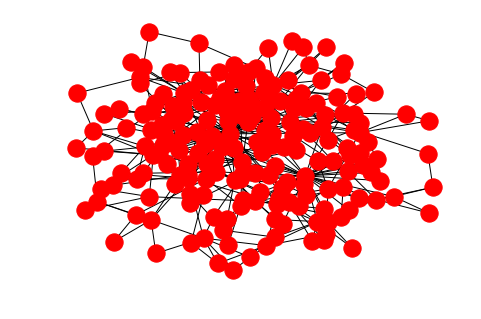

[2, 4, 8, 15, 33, 53, 81, 99, 114, 128, 142, 159, 168, 178, 183, 188, 192, 194, 196, 198, 199, 199, 199, 199, 200]


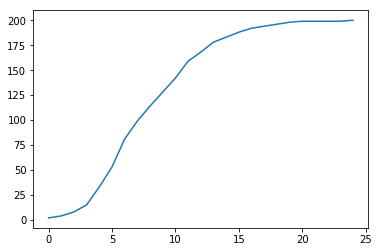

In [16]:
abnm = ABNMExperiment(model="powerlaw_cluster", num_nodes=200, num_edges=2, p=0.5,
                      number_of_initial_infected=2,
                      population_p=1,
                      beta=0.1,
                      verbose=False,
                      plot=False)
abnm.run()
nx.draw(abnm.graph)
plt.show()
print(abnm.infection_history)
plt.plot(abnm.infection_history)
plt.show()

## Interactive random graph generator 

In [17]:
interact(plot_random_graph, n=(10,100), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
         generator={
             'power law': powerlaw_cluster,
             'Newman-Watts-Strogatz': newman_watts_strogatz,
             u'Erdős-Rényi': erdos_renyi,
         });

A Jupyter Widget